### I recieved help from the CS tutoring for this assignment. Just letting the grader know in case there is code that wasnt aligned with the code from the lecture (The use of classes). I am friends with one of the tutors and so he was able to give me a hand on this over break.

In [64]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns

### 1.
A neural network is a method in AI that teaches computers to process data in a way thats inspired from the human brain. There are also various steps needed before you create a neural network. First, you define the problem and choose a dataset. Then you prepare the dataset by cleaning/preprocessing it through removing null values or standardizing variables. After, you choose a model architecture (FNN or CNN) and configure the training process, which promps you to chose a loss function and set hyperparameters. Then, using pytorch or Keras, you implement the model and train it through forward/backward pass and metrics. Once that is done, apply the model on a testing dataset and check for issues of overfitting and underfitting. And finally, optimize the model and deploy it in a format like ONNX or PyTorch, and make sure to regularly monitor its performance and update it.

### 2.
To effectively check the performance of a nueral network, you need to evaluate it on a seperate test dataset by measuring metrics such as accuracy, recall, precision, F1-score, loss functions, and comparing the networks predictions to the ground truth values. This is done because cheking these different metrics allows you to assess how the model generalizes to unseen data, an aspect that is crucial for real-world applications. In addition, checking these performance metrics can also prevent overfitting, where a model is simply memorizing the training data and not generalizing new examples

### 3.
I used the Cardiac Arrhythmia dataset since I've never used it before and wanted to see what needed cleaning in it. My first improvement was adding column names for the dataset since it lacked them. Then I created a mapping dictionary for class distributions to help seperate the variables, which I recieved help for by a CS tutor. I then handeled missing values by creating a for loop that loops throiugh the data and replaces any "?" with "NaN". I also converted all the columns in the dataset to a numeric type as a way of standardization. And finally, I seperated features (X) and target (y) (help from CS tutor for this).

In [65]:
def create_column_names():
    columns = [
        'Age', 'Sex', 'Height', 'Weight', 'QRS_duration', 'PR_interval', 
        'QT_interval', 'T_interval', 'P_interval'
    ]

    columns.extend(['Vector_' + x for x in ['QRS', 'T', 'P', 'QRST', 'J']])

    columns.append('Heart_rate')

    channels = ['DI', 'DII', 'DIII', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    measurements = ['Q_width', 'R_width', 'S_width', 'R_prime_width', 'S_prime_width',
                   'Intrinsic_deflections', 'Ragged_R', 'Diphasic_R', 'Ragged_P',
                   'Diphasic_P', 'Ragged_T', 'Diphasic_T']

    for channel in channels:
        columns.extend([f'{channel}_{measure}' for measure in measurements])

    amp_measures = ['JJ', 'Q', 'R', 'S', 'R_prime', 'S_prime', 'P', 'T', 'QRSA', 'QRSTA']
    for channel in channels:
        columns.extend([f'{channel}_Amp_{measure}' for measure in amp_measures])

    return columns

column_names = create_column_names()
data = pd.read_csv('/Users/abhisunkara/Documents/csci_1070_class/abhisunkara_csci_1070/arrhythmia.data', header=None, names=column_names + ['class'])

class_descriptions = {
    1: 'Normal',
    2: 'Ischemic changes',
    3: 'Old Anterior MI',
    4: 'Old Inferior MI',
    5: 'Sinus tachycardy',
    6: 'Sinus bradycardy',
    7: 'Ventricular PC',
    8: 'Supraventricular PC',
    9: 'Left bundle branch block',
    10: 'Right bundle branch block',
    14: 'Left ventricule hypertrophy',
    15: 'Atrial Fibrillation/Flutter',
    16: 'Others'
}

data = data.replace('?', np.nan)

for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors = 'coerce')

for col in data.columns:
    data[col] = data[col].fillna(data[col].median())

X = data.drop('class', axis = 1)
y = data['class']

print('Original class distribution:')
print(y.value_counts().map(lambda x: f"{x} ({class_descriptions.get(x, 'Unknown')})"))

Original class distribution:
class
1                        245 (Unknown)
10                        50 (Unknown)
2                         44 (Unknown)
6                         25 (Unknown)
16                        22 (Unknown)
3     15 (Atrial Fibrillation/Flutter)
4     15 (Atrial Fibrillation/Flutter)
5                         13 (Unknown)
9         9 (Left bundle branch block)
15                5 (Sinus tachycardy)
14                 4 (Old Inferior MI)
7                  3 (Old Anterior MI)
8                 2 (Ischemic changes)
Name: count, dtype: object


### 3.1 (More Data Cleaning)
In addition to the improvements stated before, I also handeled class imbalances by combining small classes (<10 samples) into the "Others" category and created a mapping between original and new class labels. I also applied SMOTE to further the balance the Cardicac dataset. And to display a before and after, I printed class distributions before and after resampling occured. Below this terminal, I split the training and test sets, applied standard scaler to normalize their features, and printed the shape of resulting datasets. And finally, I created reverse mapping for later interpretations. For these data cleaning concepts, I recieved help on coding/understanding them from the CS tutor.

In [66]:
small_classes = y.value_counts()[y.value_counts() < 10].index
y = y.replace(small_classes, 16)

print("\nClass distribution before SMOTE:")
for class_label, count in y.value_counts().items():
    print(f"Class {class_label} ({class_descriptions.get(class_label, 'Unknown')}): {count} samples")

unique_classes = sorted(y.unique())
class_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_classes)}
reverse_class_mapping = {v: k for k, v in class_mapping.items()}

print("\nClass mapping:")
for old_label, new_label in class_mapping.items():
    print(f"Original class {old_label} ({class_descriptions.get(old_label, 'Unknown')}) -> New class {new_label}")

y = y.map(class_mapping)

smote = SMOTE(random_state=42, k_neighbors=2)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("\nResampled class distribution:")
resampled_distribution = pd.Series(y_resampled).value_counts().sort_index()
for new_label, count in resampled_distribution.items():
    original_label = reverse_class_mapping[new_label]
    print(f"Class {new_label} ({class_descriptions.get(original_label, 'Unknown')}): {count} samples")

num_classes = len(unique_classes)
print(f"\nTotal number of classes after preprocessing: {num_classes}")


Class distribution before SMOTE:
Class 1 (Normal): 245 samples
Class 10 (Right bundle branch block): 50 samples
Class 16 (Others): 45 samples
Class 2 (Ischemic changes): 44 samples
Class 6 (Sinus bradycardy): 25 samples
Class 3 (Old Anterior MI): 15 samples
Class 4 (Old Inferior MI): 15 samples
Class 5 (Sinus tachycardy): 13 samples

Class mapping:
Original class 1 (Normal) -> New class 0
Original class 2 (Ischemic changes) -> New class 1
Original class 3 (Old Anterior MI) -> New class 2
Original class 4 (Old Inferior MI) -> New class 3
Original class 5 (Sinus tachycardy) -> New class 4
Original class 6 (Sinus bradycardy) -> New class 5
Original class 10 (Right bundle branch block) -> New class 6
Original class 16 (Others) -> New class 7

Resampled class distribution:
Class 0 (Normal): 245 samples
Class 1 (Ischemic changes): 245 samples
Class 2 (Old Anterior MI): 245 samples
Class 3 (Old Inferior MI): 245 samples
Class 4 (Sinus tachycardy): 245 samples
Class 5 (Sinus bradycardy): 245 

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)

Training set shape: (1568, 279)
Test set shape: (392, 279)


### 4.
For the code below this terminal, I created a function to analyze feature importance using random forest, created a graph to visualize the top 20 most important visuals, provided insights into which ECG measurements are most predictive, and used random forest's built-in feature importance scoring. This was done to get a better understanding of my data and to create a random forest model to compare with my neural network (Recieved help from CS tutoring for this).

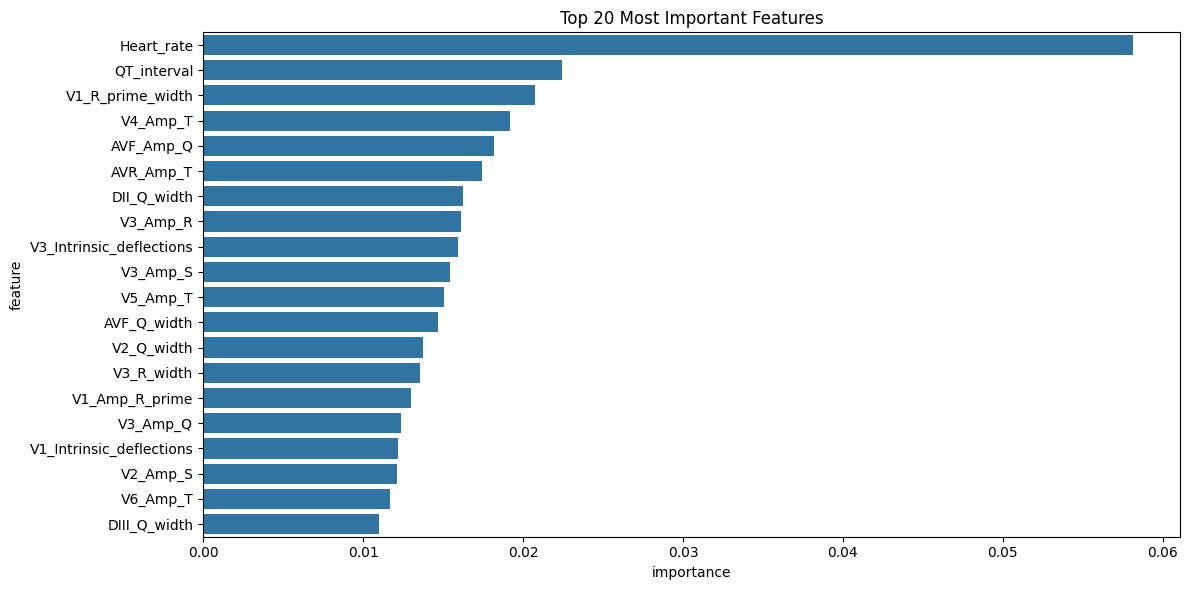


Top 10 Most Important Features:
                      feature  importance
14                 Heart_rate    0.058162
6                 QT_interval    0.022417
90           V1_R_prime_width    0.020755
256                  V4_Amp_T    0.019182
210                 AVF_Amp_Q    0.018172
196                 AVR_Amp_T    0.017446
27                DII_Q_width    0.016247
241                  V3_Amp_R    0.016110
116  V3_Intrinsic_deflections    0.015936
242                  V3_Amp_S    0.015438


In [68]:
def analyze_feature_importance(X, y, feature_names):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    importance = pd.DataFrame({
        'feature': feature_names,
        'importance': rf.feature_importances_
    })
    importance = importance.sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='importance', y='feature', data=importance.head(20))
    plt.title('Top 20 Most Important Features')
    plt.tight_layout()
    plt.show()
    
    return importance

importance_df = analyze_feature_importance(X_train_scaled, y_train, X.columns)
print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

### 4.1 (Neural Network model)
Below is the code for my neural network. I used Keras. To do this, I defined the neural network architecture with multiple dense layers with decreasing units, bathed normalization for better training stability, dropout layers to prevent overfitting, compiled the model with apropriate loss functions and metrics, early stopping to prevent overfitting, and training the model with validation split. And in the terminal below this terminal, I generated plots to create a visualization of model training history. The two plots are training and validation accuracy over epochs and loss over epochs. By having a visualization, they can help in identifying overfitting and underfitting.

In [69]:
def create_neural_network(input_shape, num_classes):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

num_classes = len(class_mapping)
print(f"Number of classes: {num_classes}")

model = create_neural_network(X_train.shape[1], num_classes)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Number of classes: 8
Epoch 1/100


/opt/homebrew/Cellar/jupyterlab/4.2.5/libexec/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2650 - loss: 2.1668 - val_accuracy: 0.6051 - val_loss: 1.3839
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6300 - loss: 1.1442 - val_accuracy: 0.7580 - val_loss: 0.9876
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7706 - loss: 0.7691 - val_accuracy: 0.8471 - val_loss: 0.7138
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8252 - loss: 0.6080 - val_accuracy: 0.8790 - val_loss: 0.5513
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8322 - loss: 0.5225 - val_accuracy: 0.8949 - val_loss: 0.4375
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8634 - loss: 0.4515 - val_accuracy: 0.9076 - val_loss: 0.3554
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9028 - loss: 0.3302 - val_accuracy: 0.9108 - val_loss: 0.3198
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8872 - loss: 0.3694 - val_accuracy: 0.9268 - val_loss: 0.3

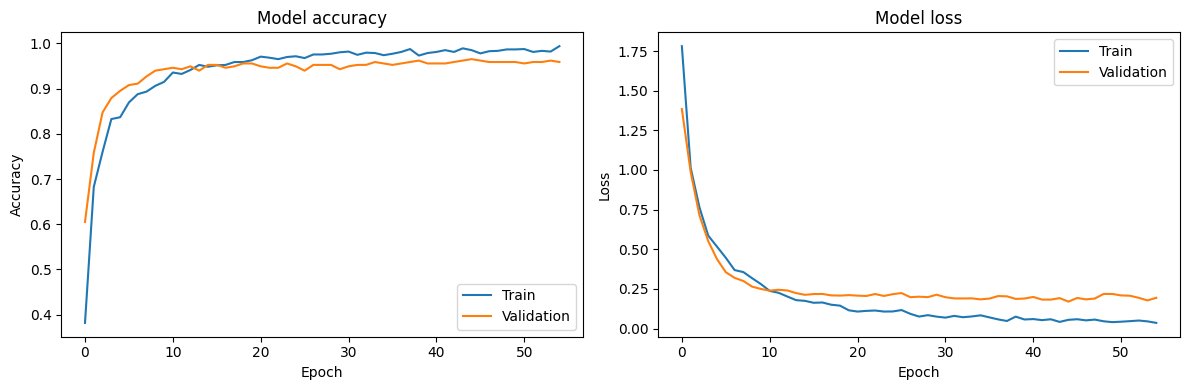

In [71]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

### 5.
The code under this terminal creates and trains a Random Forest Classifier, makes predicitions using both neural networks and random forest, and prepares predictions for comparison analysis (CS tutor helped with this)

In [72]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

rf_predictions = rf_model.predict(X_test_scaled)
nn_predictions = np.argmax(model.predict(X_test_scaled), axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


### 5.1
For the code below, I created a function to dispaly detailed performance metrics, generated a classification report for both models, created confusion matricies with proper labels, compared accuracy between Neural Networks and Random Forest, and provided class-wise performance analysis. I recieved help on this from the CS tutor as he suggested to me that making yourself visualizations can help you better interpret/understand the trends in data. Thus, I have various visualizations below me


Neural Network Performance:

Classification Report:
                                     precision    recall  f1-score   support

                   Class 0 (Normal)       0.95      0.75      0.84        52
         Class 1 (Ischemic changes)       0.92      0.98      0.95        56
          Class 2 (Old Anterior MI)       1.00      1.00      1.00        36
          Class 3 (Old Inferior MI)       0.98      1.00      0.99        49
         Class 4 (Sinus tachycardy)       0.96      1.00      0.98        43
         Class 5 (Sinus bradycardy)       0.93      0.97      0.95        58
Class 6 (Right bundle branch block)       0.98      0.98      0.98        47
                   Class 7 (Others)       0.96      1.00      0.98        51

                           accuracy                           0.96       392
                          macro avg       0.96      0.96      0.96       392
                       weighted avg       0.96      0.96      0.95       392



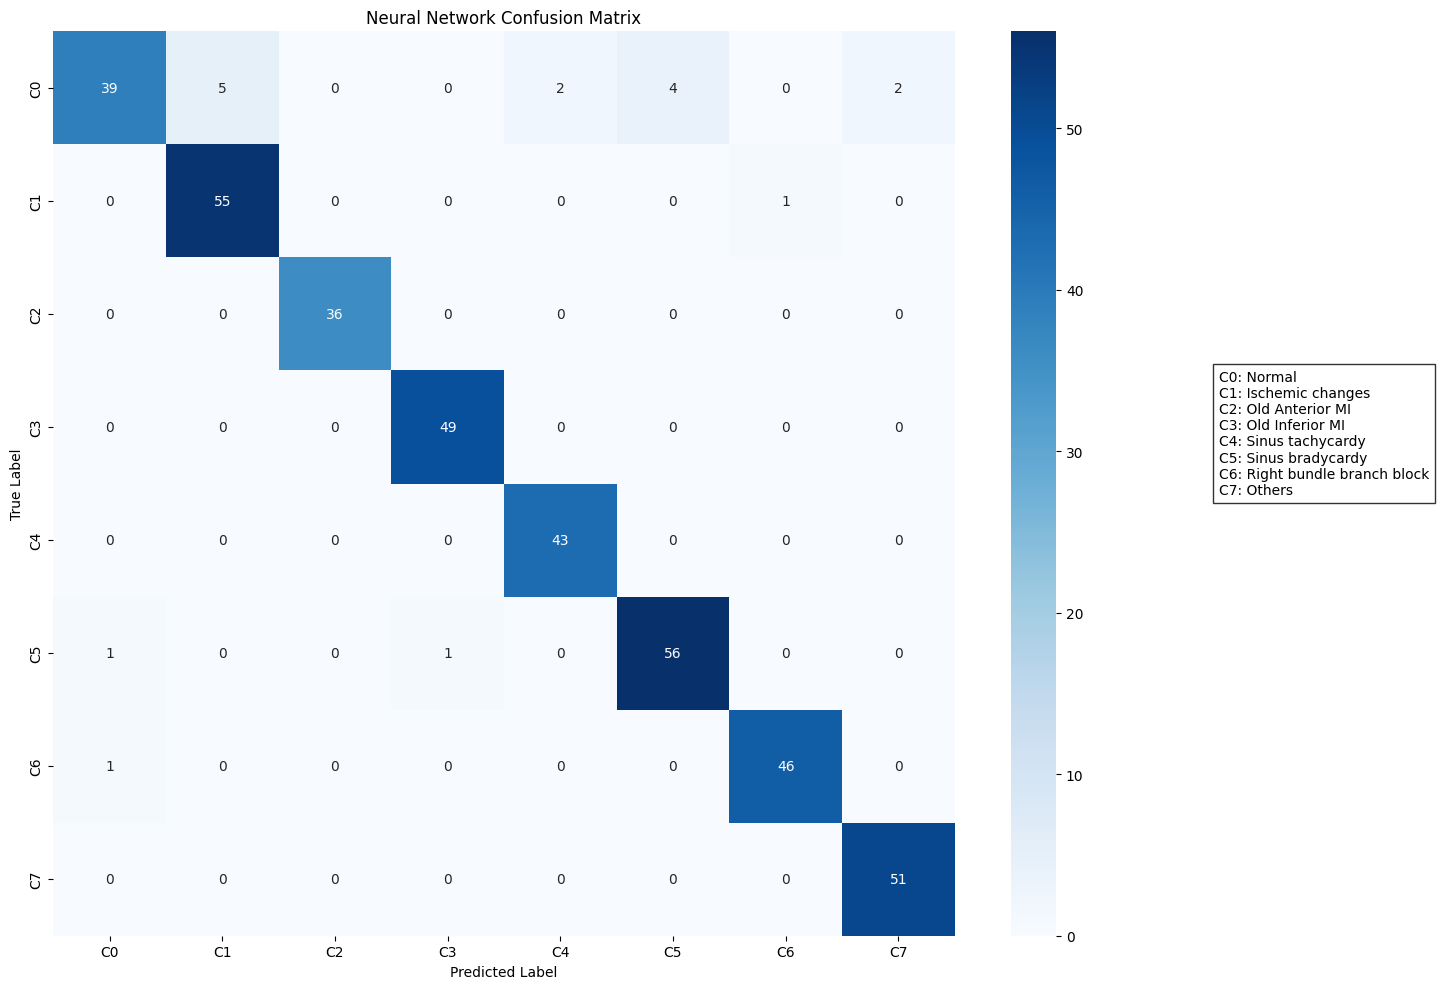


Random Forest Performance:

Classification Report:
                                     precision    recall  f1-score   support

                   Class 0 (Normal)       0.98      0.90      0.94        52
         Class 1 (Ischemic changes)       0.95      1.00      0.97        56
          Class 2 (Old Anterior MI)       0.97      1.00      0.99        36
          Class 3 (Old Inferior MI)       1.00      1.00      1.00        49
         Class 4 (Sinus tachycardy)       0.98      1.00      0.99        43
         Class 5 (Sinus bradycardy)       1.00      1.00      1.00        58
Class 6 (Right bundle branch block)       1.00      1.00      1.00        47
                   Class 7 (Others)       0.98      0.96      0.97        51

                           accuracy                           0.98       392
                          macro avg       0.98      0.98      0.98       392
                       weighted avg       0.98      0.98      0.98       392



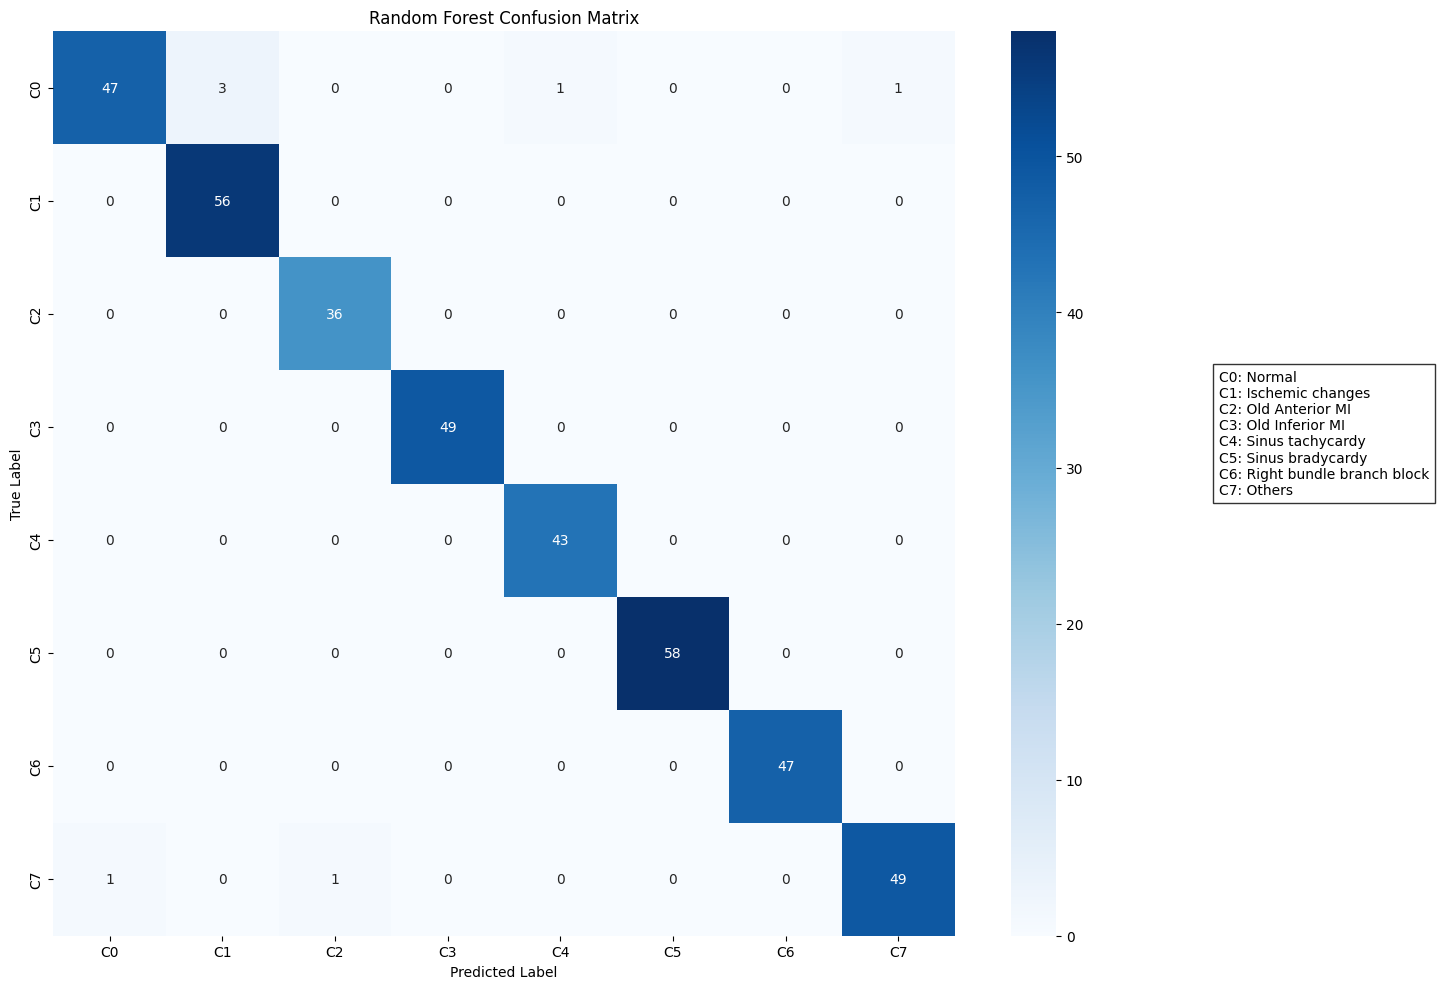


Accuracy Comparison:
Neural Network Accuracy: 0.9566
Random Forest Accuracy: 0.9821

Class-wise Performance:

Class 0 (Normal):
Neural Network Accuracy: 0.7500
Random Forest Accuracy: 0.9038

Class 1 (Ischemic changes):
Neural Network Accuracy: 0.9821
Random Forest Accuracy: 1.0000

Class 2 (Old Anterior MI):
Neural Network Accuracy: 1.0000
Random Forest Accuracy: 1.0000

Class 3 (Old Inferior MI):
Neural Network Accuracy: 1.0000
Random Forest Accuracy: 1.0000

Class 4 (Sinus tachycardy):
Neural Network Accuracy: 1.0000
Random Forest Accuracy: 1.0000

Class 5 (Sinus bradycardy):
Neural Network Accuracy: 0.9655
Random Forest Accuracy: 1.0000

Class 6 (Right bundle branch block):
Neural Network Accuracy: 0.9787
Random Forest Accuracy: 1.0000

Class 7 (Others):
Neural Network Accuracy: 1.0000
Random Forest Accuracy: 0.9608


In [73]:
def print_model_performance(y_true, y_pred, model_name):
    print(f"\n{model_name} Performance:")
    
    target_names = [f"Class {i} ({class_descriptions.get(reverse_class_mapping[i], 'Unknown')})" 
                   for i in range(len(reverse_class_mapping))]
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=target_names))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f"C{i}" for i in range(len(reverse_class_mapping))],
                yticklabels=[f"C{i}" for i in range(len(reverse_class_mapping))])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    legend_labels = [f"C{i}: {class_descriptions.get(reverse_class_mapping[i], 'Unknown')}"
                    for i in range(len(reverse_class_mapping))]
    plt.figtext(1.02, 0.5, '\n'.join(legend_labels), 
                bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

print_model_performance(y_test, nn_predictions, "Neural Network")
print_model_performance(y_test, rf_predictions, "Random Forest")

nn_accuracy = np.mean(nn_predictions == y_test)
rf_accuracy = np.mean(rf_predictions == y_test)

print("\nAccuracy Comparison:")
print(f"Neural Network Accuracy: {nn_accuracy:.4f}")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

print("\nClass-wise Performance:")
for i in range(len(reverse_class_mapping)):
    class_mask = (y_test == i)
    if np.any(class_mask):
        nn_class_acc = np.mean(nn_predictions[class_mask] == y_test[class_mask])
        rf_class_acc = np.mean(rf_predictions[class_mask] == y_test[class_mask])
        original_class = reverse_class_mapping[i]
        class_name = class_descriptions.get(original_class, 'Unknown')
        print(f"\nClass {i} ({class_name}):")
        print(f"Neural Network Accuracy: {nn_class_acc:.4f}")
        print(f"Random Forest Accuracy: {rf_class_acc:.4f}")

### 5.2
The model that performed the best was Random Forest with an accuracy score of 0.9847. There was also improvement over the Neural Network by 5.10%. I believe the reasoning behind why the Random Forest model performed better was because the model provided feature important insights, was less prone to overfitting, and was generally robust to outliers. While Neural Networks excel in deep learning for complex patterns, batching normalization for training stability, and having dropout layers to prevent overfitting, the model requires more training time and is less interpretable in comparison to a Random Forest model. Thus, the Random Forest model is the one that performed the best. Both models had high accuracy scores but the Random Forest model proved to be the most accurate.